In [1]:
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
torch.cuda.empty_cache()


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Path for importing Coh2 Environment
sys.path.append("./test_functions")
torch.cuda.empty_cache()

For plotting the surface:

In [2]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(350, 2500, n)
    x2 = torch.linspace(350, 2500, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T
    
    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')
    
    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

Loading the full dataset:

In [3]:
#load coh2(); this object allows to query coheritability of ratios
import coh2
trait = "narea"
lookup = coh2.Coh2(trait, base_path="./") #base_path is the path with the csv files

In [4]:
# #generate random training and test set
seed = 1
split = 1 #0.85 #percent training data
n = 100000#2151 ** 2 #load full dataset


torch.manual_seed(seed)

#randomly generate the data
torch.manual_seed(seed)
data_X = torch.rand((n,2)) * (2500 - 350) + 350  
data_X = data_X.to(device)
data_Y = lookup(data_X).to(device)

# # #use all data
# data_X = torch.tensor(
#     [[i, j] for i in range(350, 2500 + 1) for j in range(350, 2151 + 1)])
# random_indices = torch.randperm(len(data_X))
# data_X = data_X[random_indices]
# data_X = data_X.to(device).float()
# data_Y = lookup(data_X).to(device)

#split into training and test sets
train_X = data_X[:int(split*n)].to(dtype=torch.float64)
train_Y = data_Y[:int(split*n)].to(dtype=torch.float64)
val_X = data_X[int(split*n):].to(dtype=torch.float64)
val_Y = data_Y[int(split*n):].to(dtype=torch.float64)

Small test to make sure the GP fitting works.

noise: 0.020698031798507103
lengthscale: tensor([[0.0273, 0.0270]], device='cuda:0', dtype=torch.float64)


/dfs/scratch0/ruhana/miniconda3/envs/genCorSearch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352595413/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


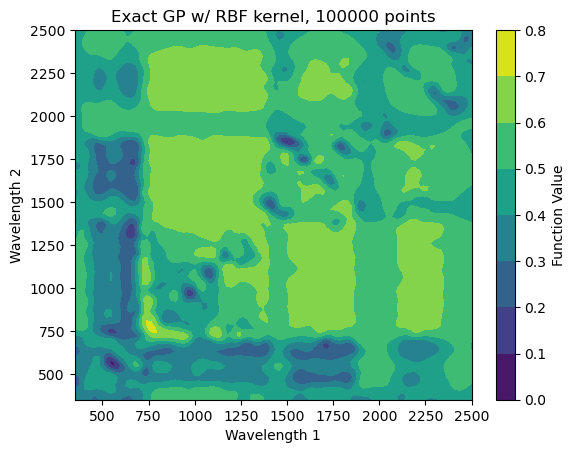

In [5]:
smoke_test = 1
if smoke_test:
    model = SingleTaskGP(train_X[:2000], train_Y[:2000].reshape(-1,1),
                                 outcome_transform=Standardize(m=1),
                                 input_transform=Normalize(train_X.shape[-1])
                                )
    # Use Exact Marginal Log Likelihood as the loss
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Fit the model
    fit_gpytorch_mll(mll, )

    #get gaussian likelihood then it has object noise 
    #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
    print(f"noise: {model.likelihood.noise.item()}")

    #Get the lengthscale
    kernel = model.covar_module.base_kernel
    print(f"lengthscale: {kernel.lengthscale.detach()}")
    
    def modelWrapper(X):
                return model.posterior(X).mean

    surfacePlot(modelWrapper, title=f"Exact GP w/ RBF kernel, {len(train_X)} points", n=100)

Run GP fitting on various levels of random points while keeping track of infered lengthscale and noise scales.

on seed=0, n=500
on seed=0, n=1000
on seed=0, n=1500
on seed=0, n=2000
on seed=0, n=2500
on seed=1, n=500


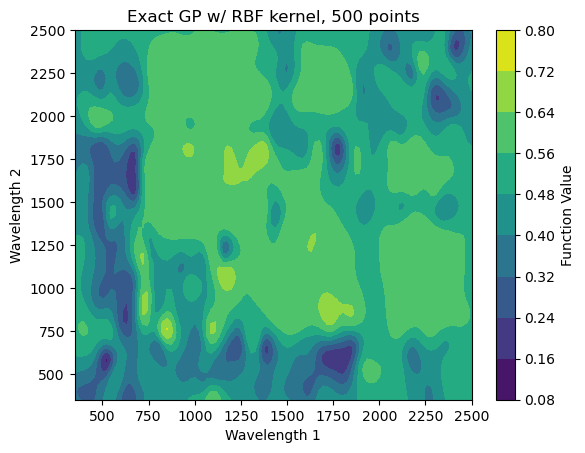

on seed=1, n=1000


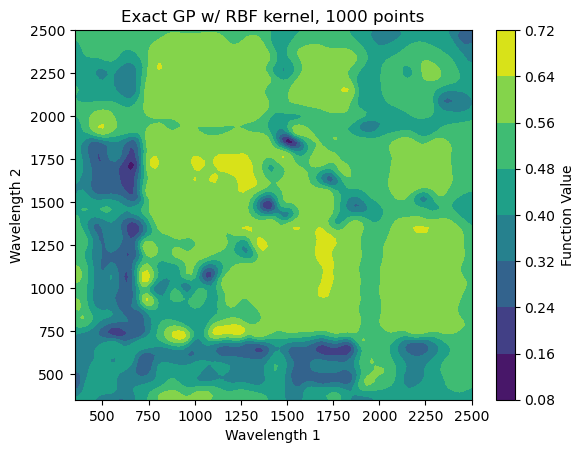

on seed=1, n=1500


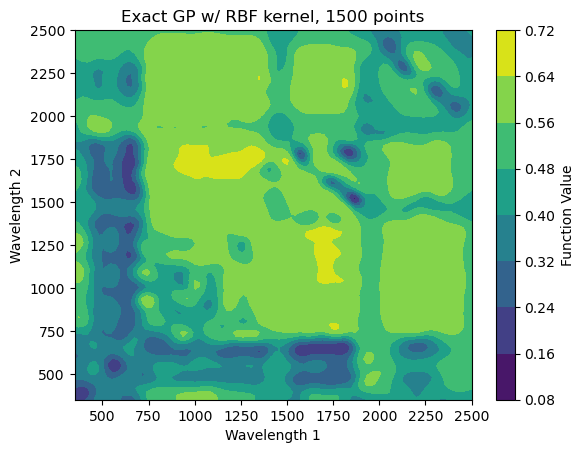

on seed=1, n=2000


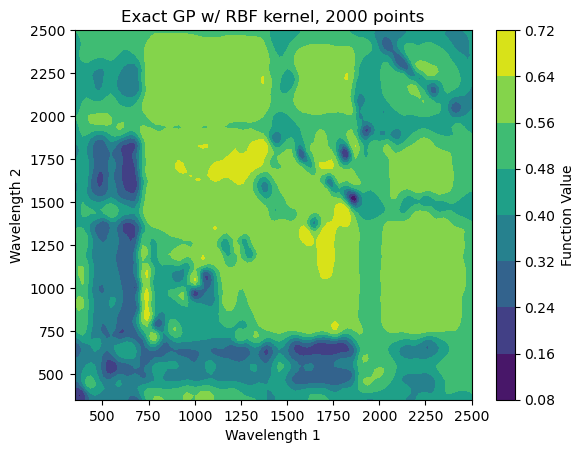

on seed=1, n=2500


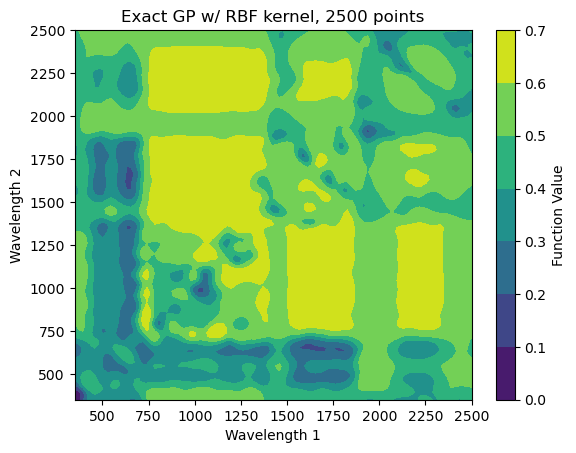

on seed=2, n=500
on seed=2, n=1000
on seed=2, n=1500


In [ ]:
seeds = 5
optionsN = [500*i for i in range(1, 6)]
experiments = {"noise": [[] for i in range(seeds)], 
               "lengthscale": [[] for i in range(seeds)]}

for s in range(seeds): #number of times to run
    lengthscales = []
    noises = []
    for n in optionsN:
        torch.cuda.empty_cache()
        # Create GP
        model = SingleTaskGP(train_X[s*n:(s+1)*n], train_Y[s*n:(s+1)*n].reshape(-1,1),
                             outcome_transform=Standardize(m=1),
                             input_transform=Normalize(train_X.shape[-1])
                            )

        # Use Exact Marginal Log Likelihood as the loss
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Fit the model
        fit_gpytorch_mll(mll, )
        
        #get gaussian likelihood then it has object noise 
        #refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
        noises.append(model.likelihood.noise.item())

        #Get the lengthscale
        kernel = model.covar_module.base_kernel
        lengthscales.append(kernel.lengthscale.detach())

        #Plot posterior mean surface
        print(f"on seed={s}, n={n}")
        if s == 1:
            def modelWrapper(X):
                return model.posterior(X).mean
            surfacePlot(modelWrapper, title=f"Exact GP w/ RBF kernel, {n} points", n=100)

    lengthscales = torch.vstack(lengthscales)
    noises = torch.tensor(noises)
    experiments["lengthscale"][s].append(lengthscales)
    experiments["noise"][s].append(noises)

In [ ]:
#plotting for lengthscale
temp = torch.stack([item[0] for item in experiments["lengthscale"]])#.shape

# Compute mean and variance over seed
mean = torch.mean(temp, dim=0).cpu()
var = torch.var(temp, dim=0).cpu()

# Plot Datasize to Length Scale relationship
for dim in range(mean.shape[-1]):
    # Plot the mean
    plt.plot(mean[:,dim], label='Lengthscale')

    # Fill between the upper and lower bounds for variance
    lower_bound = mean[:,dim] - var[:,dim]
    upper_bound = mean[:,dim] + var[:,dim]
    plt.fill_between(range(len(mean)), lower_bound, upper_bound, alpha=0.2)

    # Add labels and a title
    plt.xlabel('N')
    plt.ylabel(f'Lengthscale')
    plt.title(f'Training Points x Lengthscale, Dim={dim}')

    # Show the plot
    plt.show()

In [ ]:
#plotting for noise
temp = torch.stack([item[0] for item in experiments["noise"]])#.shape

# Compute mean and variance over seed
mean = torch.mean(temp, dim=0).cpu()
var = torch.var(temp, dim=0).cpu()

# Plot Datasize to Length Scale relationship

# Plot the mean
plt.plot(mean[:], label='Lengthscale')

# Fill between the upper and lower bounds for variance
lower_bound = mean[:] - var[:]
upper_bound = mean[:] + var[:]
plt.fill_between(range(len(mean)), lower_bound, upper_bound, alpha=0.2)

# Add labels and a title
plt.xlabel('N')
plt.ylabel(f'Infered Noise')
plt.title(f'Training Points x Infered Noise')

# Show the plot
plt.show()